# MORPHOLOGY TEST

In [14]:
import numpy as np
from matplotlib import pyplot, cm
from neuron import h,gui
from neuron.units import mV, ms, sec, um, us

#%matplotlib inline
# c compiler
#!nrnivmodl vecevent.mod
#!nrnivmodl L5bPCmodelsEH/mod/

In [15]:
def CreateAdjancyM(Labels):

    N = len(Labels)

    A = np.zeros([N,N],dtype=np.int32)

    for i in range(len(Labels)):

        dd = str(eval('h.'+Labels[i]).psection()['morphology']['trueparent']).split('(')[0]

        try:
            j = Labels.index(dd)

            A[i,j] = 1

        except:
            pass
        
    return A


In [16]:
def createSynapse(dend,dendIdx, loc=0.5, tau=[2*ms, 4*ms], e=0*mV):
    """Creates an excitatory synapse on the dendrite given by Idx."""
    syn = h.Exp2Syn(dend[dendIdx](loc))
    syn.tau1 = tau[0]
    syn.tau2 = tau[1]
    syn.e = e
    return syn 

def createNMDA_Synapse(dend,dendIdx, loc=0.5, tau=[2*ms, 20*ms], e=0*mV):
    """Creates an excitatory synapse on the dendrite given by Idx."""
    syn = h.Exp2SynNMDA(dend[dendIdx](loc))
    syn.tau1 = tau[0]
    syn.tau2 = tau[1]
    syn.e = e
    return syn 

def createStim(isi=20*ms, num=100, start=1*ms, noise=1, seed=9):
    stim = h.NetStim()
    stim.interval = isi
    stim.number = num
    stim.start = start
    stim.noise = noise
    stim.noiseFromRandom123(seed, 0, 0)
    stim.seed(seed)
    
    return stim

def connectStim(syn, stim, delay=1*ms, weight=0.4):
    conn = h.NetCon(stim, syn)
    conn.delay = delay
    conn.weight[0] = weight
    
    return conn

def createStim(isi=20*ms, num=100, start=1*ms, noise=1, seed=9):
        stim = h.NetStim()
        stim.interval = isi
        stim.number = num
        stim.start = start
        stim.noise = noise
        stim.noiseFromRandom123(seed, 0, 0)
        stim.seed(seed)
        return stim

def homogeneous_poisson(rate, tmax, bin_size):
    "Rate in Hz, Tmax and bin_size in ms"
    
    nbins = np.floor(tmax/bin_size).astype(int)
    
    prob_of_spike = rate * bin_size / 1e3 #In ms^-1
    
    spikes = np.random.rand(nbins) < prob_of_spike
    
    return spikes * 1

def Background_noise(rate,bin_size,tmax,numInputs):

    BoolTS = homogeneous_poisson(rate, tmax, bin_size)
    
    return [np.where(BoolTS==1)[0]*bin_size for i in range(numInputs)],BoolTS

def CreateVecStim(numInputs,tmax,rate=10,bin_size=0.1):

    Noise,BoolTS = Background_noise(rate,bin_size,tmax,numInputs)

    stimulations = [h.VecStim() for i in range(numInputs)]

    Noivec = [h.Vector(Noise[i]) for i in range(numInputs)]

    for i in range(numInputs):
        
        stimulations[i].play(Noivec[i])
    
    return stimulations,Noise,BoolTS

np.random.seed(12345)


In [17]:

def CorrInputs(tmax,rate,Nsour=2,bin_size=1,a=0,b=1000):
    
    Noiseb,BoolTS = Background_noise(rate,bin_size,tmax,1)
    
    NoiseCorr = []
    
    NoiseCorr.append(np.int32(np.round(Noiseb[0])))
    
    for i in range(Nsour-1):

        DerI = np.int32(np.round(Noiseb[0] + np.random.normal(a,b,len(Noiseb))))

        #Inputs should be inside the simulation time interval
        DerI *= 1*(DerI >= 0)*(DerI < tmax)

        #Delete inputs at 0 s
        DerI = [i for i in DerI if i!=0]

        NoiseCorr.append(np.array(DerI))
    
    stimulationsSour = [h.VecStim() for i in range(Nsour)]

    NoivecS = [h.Vector(NoiseCorr[i]) for i in range(Nsour)]

    for i in range(Nsour):
        
        stimulationsSour[i].play(NoivecS[i])
    
    return stimulationsSour

def BooleanInputInfo(NoiseCorrt,tmax,bin_size,numSour):
    
    St = np.arange(0,tmax,bin_size)

    Sbool = np.zeros([numSour,St.shape[0]],dtype=np.int8)

    for i in range(len(NoiseCorrt)):

        for j in NoiseCorrt[i]:

            Sbool[i,np.where(St==j)] = 1
    
    return Sbool

from scipy.ndimage import gaussian_filter1d
import numpy as np

def InputCorr(Inputs):
    
    S = np.zeros([len(Inputs),len(Inputs[0])])

    sigma = 1

    for i in range(len(Inputs)):

        S[i,np.where(Inputs[i]==1)[0]] = 1
        S[i,np.where((S[1:]-S[:-1])==1)[0]] = 0.5
        S[i,np.where((S[1:]-S[:-1])==-1)[0]+1] = 0.5

        S[i] = gaussian_filter1d(S[i],sigma)

    cor = np.corrcoef(S[0],S[1])[0,1]

    return cor

def EI_Synaptic_info(numNoiseInputs,pp = [0.8,0.2]):
    
    es = [0,-80]

    ee = np.random.choice(es,numNoiseInputs,p=pp)

    loc = np.round(np.random.uniform(0,1,numNoiseInputs),3)
    
    return ee,loc


In [18]:

def ShanonEntropy(X):
    
    if len(X.shape)>1:
        t,size = X.shape
        
        base = np.array([2**i for i in range(size)])

        Xst = np.dot(X,base)

    else:
        size = 1
        
        Xst = 1*X
    
    states,counts = np.unique(Xst,return_counts=True)

    H = 0

    for i in range(len(states)):

        p = counts[i]/np.sum(counts)

        H += -p*np.log(p)
    
    return H

def IMf(x,y):
    
    h1 = ShanonEntropy(x)
    
    h2 = ShanonEntropy(y)

    h3 = ShanonEntropy(np.column_stack((x,y)))

    return h1+h2-h3

def PID(T,X):
    
    RR = np.min([IMf(T,X[:,0]),IMf(T,X[:,1])])
    
    ru1 = IMf(X[:,0],T)
    ru2 = IMf(X[:,1],T)
        
    U1 = ru1 - RR

    U2 = ru2 - RR
    
    Syn = IMf(X,T) - ru1 - ru2 + RR
        
    return [RR,U1,U2,Syn]

def PID_analysis(recordings,Input_bin_size=1,thres=-30,tau=1,Timebining=1,skip=2000):
    
    tmax = int(np.round(recordings["time"][-1]))
    
    numSour = len(recordings["inputTime"])
    
    Inputs = BooleanInputInfo(recordings["inputTime"],tmax,Input_bin_size,numSour)
    
    Vsoma = 1*(recordings["soma"] > thres)[ini:]

    t = recordings["time"]

    dt = np.mean(t[1:]-t[:-1])
    
    tw = int(np.round(Input_bin_size/dt))
    
    Ts0 = int(len(Vsoma)/tw)
    
    bolskip = int(ini*dt/Input_bin_size)
    
    T = int((len(Inputs[0])-bolskip)/Timebining)

    #Equalize input and soma time series    
    Somabool = np.zeros(Ts0,dtype=np.int8)
    
    for i in range(Ts0-1):

        Somabool[i] = np.sum(Vsoma[tw*i:tw*(i+1)])>0
    
    ######################################
    SS = [Somabool]
    
    for i in range(len(Inputs)):
        
        SS.append(Inputs[i][bolskip:])
    
    timeS = np.zeros([len(SS),T],dtype=np.int32)
    
    for j in range(len(SS)):

        for i in range(T-1):

            timeS[j,i] = np.int32(1*(np.sum(SS[j][i*Timebining:(i+1)*Timebining])>0))
    
    T = timeS[0,tau:]

    Xs = timeS[1:,:-tau].T

    Red,U1,U2,Syn = PID(T,Xs)
    
    cor = InputCorr(Inputs)

    return [Red,np.max([U1,U2]),Syn,cor]


In [19]:

def Synapse_3Dpos(PathsD,inputsIdx,loc):
    """
    Compute the position of each synapse in the detailed dendritic branch
    """
    
    SynapsePos = []

    for j in range(len(loc)):
        #To idenfity closes point to loc value
        vec = PathsD[inputsIdx[j]][1:,:-1]-PathsD[inputsIdx[j]][:-1,:-1]
        
        if len(vec)>1:

            ll = []

            l = 0

            ll.append(l)

            for i in np.linalg.norm(vec,axis=1):

                l += i

                ll.append(l)

            #loc distance across the path
            dloc = ll[-1]*loc[j]

            Vidx = np.argsort(np.abs(ll-dloc))[:2]

            #pts3d points between loc point
            V1,V2 = PathsD[inputsIdx[j]][Vidx,:-1]

            #loc parameter
            vn = np.linalg.norm(V2-V1)

            if vn>0:
                t = (dloc-ll[Vidx[0]])/vn
            else:
                t = 0

            #loc vector (3D line equation)
            VX = V1 + (V2-V1)*t

            SynapsePos.append(VX)

        else:
            
            SynapsePos.append(PathsD[inputsIdx[j]][0])
    
    return SynapsePos

def Plot3D(name,ddir="",inputsIdx=[],loc=[],secIndx=[],sTyp='b',ax=None,scale=False,SS=1,SSa=0.1,cl=None,clp=[],LW=0.5):
    """
    3D plot of the neuron morphology highliting soma and inputs sections. 
    Warning: Needs h define as global object with cell morphology data already loaded in it.
    Params:
        - name: Filename to save the figure
        - inputsIdx: Index of sections receiving the inputs
    """
    
    Sections = [i for i in h.allsec()]
    
    #if len(secIndx)==0:
    Paths = [np.array(eval("h."+str(Sections[i])).psection()['morphology']['pts3d']) for i in range(len(Sections))]
    #else:
    #    Paths = [np.array(eval("h."+str(Sections[i])).psection()['morphology']['pts3d']) for i in secIndx]
        
    if ax==None:
        ax = pyplot.figure().add_subplot(projection='3d')
    
    SomaSec = [i for i in range(len(Sections)) if "soma" in str(Sections[i])]
        
    # Plot dendritic branches
    ############################.
    for i in range(0,len(Paths)):

        if len(Paths[i])>0:
            xp = Paths[i][:,0]
            zp = Paths[i][:,1]
            yp = Paths[i][:,2]
    
            if len(clp)==0:
                ax.plot(xp,yp,zp,'-k',linewidth=LW)
                
            else:
                if i in secIndx:
                    j = np.where(secIndx==i)[0][0]
                    ax.plot(xp,yp,zp,'-',color=clp[j],linewidth=LW,zorder=3)
                    
                else:
                    ax.plot(xp,yp,zp,'-k',linewidth=0.25,zorder=1)
                 
    # Plot soma
    ########################
    for i in SomaSec:
        
        if len(Paths[i])>0:
            ax.plot(Paths[i][:,0],Paths[i][:,2],Paths[i][:,1],'ro',ms=5,alpha=0.25,label="Soma")
        else:
            ax.plot(0.,0.,0.,'ro',ms=5,label="Soma",alpha=0.25)
       
    # Plot synapses positions
    ###########################
    PathsD = [np.array(eval("h."+str(i)).psection()['morphology']['pts3d']) for i in Sections if ("axon" not in str(i))and("soma" not in str(i))]
    
    if len(inputsIdx)>0:

        SynapsePos = Synapse_3Dpos(PathsD,inputsIdx,loc)

        SyD = []
        
        for i in range(len(SynapsePos)):

            xp = SynapsePos[i][0]
            zp = SynapsePos[i][1]
            yp = SynapsePos[i][2]

            LabS = "Synapses"
            
            if len(sTyp)==2:

                if sTyp[i] == "b":
                    
                    LabS = "I synapses"

                    ax.plot(xp,yp,zp,'o',color=sTyp[i],ms=SS,alpha=SSa,label=LabS)

                    if LabS not in SyD:
                        
                        SyD.append(LabS)
                    
                elif sTyp[i] == "r":
                    
                    LabS = "E synapses"   

                    ax.plot(xp,yp,zp,'o',color=sTyp[i],ms=SS,alpha=SSa,label=LabS)

                    if LabS not in SyD:
                        
                        SyD.append(LabS)

                else:
                    
                    ax.plot(xp,yp,zp,'o',color=sTyp[i],ms=SS,alpha=SSa,label=LabS)

            else:
                if i==0:
        
                    if cl==None:
                        
                        ax.plot(xp,yp,zp,'o',color=sTyp[i],ms=SS,alpha=SSa)
                        
                    else:
                        ax.plot(xp,yp,zp,'o',color=cl[i],ms=SS,alpha=SSa,label="Branching")
                        
                else:
                    xp = SynapsePos[i][0]
                    zp = SynapsePos[i][1]
                    yp = SynapsePos[i][2]
    
                    if cl==None:
                        ax.plot(xp,yp,zp,'ob',ms=SS,alpha=SSa)
                        
                    else:
                        ax.plot(xp,yp,zp,'o',color=cl[i],ms=SS,alpha=SSa)            

    #Plot scale and ticks labels 
    ########################
    ps = []
    
    for j in [0,2,1]:

        pmin = np.min([np.min(Paths[i][:,j]) for i in range(len(Paths)) if len(Paths[i])>1])
        pmax = np.max([np.max(Paths[i][:,j]) for i in range(len(Paths)) if len(Paths[i])>1])

        ps.append([pmin,pmax])

    ax.set_aspect('equal')
    
    if scale==True:
    
        from mpl_toolkits.axes_grid1.anchored_artists import AnchoredSizeBar
        
        scalebar = AnchoredSizeBar(ax.transData, 2e-2, r"200 $\mu$m", 3,frameon=False,pad=5)

        ax.add_artist(scalebar)

    ax.set_xticks(np.arange(100*(ps[0][0]//100),100*(ps[0][1]//100)+100,200))
    ax.set_yticks(np.arange(100*(ps[1][0]//100),100*(ps[1][1]//100)+100,200))
    ax.set_zticks(np.arange(100*(ps[2][0]//100),100*(ps[2][1]//100)+100,200));
    ##############################
    
    ax.set_xlabel(r"$\mu$m")
    ax.set_ylabel(r"$\mu$m")
    ax.set_zlabel(r"$\mu$m")
    
    ax.legend(loc=(0.75,0.8),markerscale=2,frameon=False)

    pyplot.savefig(ddir+"Neuron_"+name+"_inputs.png",dpi=500,bbox_inches="tight")

    return ax


In [20]:
h.nrn_load_dll("x86_64/vecevent.so")

#filename = "DATA/Pyrp22.hoc"

#h.load_file(filename)

#h.nrn_load_dll("x86_64/vecevent.so")

ddir = "L5bPCmodelsEH/"
    
h.load_file("import3d.hoc")
h.load_file("nrngui.hoc")
#h.load_file("stdgui.hoc")
#h.load_file(ddir+"init.hoc")

morphology_file = ddir+"morphologies/cell1.asc"

h.load_file(ddir+"models/L5PCbiophys3.hoc")
h.load_file(ddir+"models/L5PCtemplate.hoc")

h.L5PCtemplate(morphology_file)

#allsec = h.allsec()


L5PCtemplate[1]

In [21]:
#h('forall delete_section()')

Labels = [str(i) for i in h.allsec() if "axon" not in str(i) and "soma" not in str(i)]

A = CreateAdjancyM(Labels)

indx = np.where(np.sum(A,axis=0)==0)[0]

#[Labels[i] for i in indx]

len(Labels)*len(Labels)*2/40/24

310.40833333333336

In [22]:

#SELECTING SECTION FOR BACKGROUND NOISE
def Select_Noise_sections(List,Sections,Cell="Pyr_p1",typ=0,rangeL=[0,1500],numNoiseInputs=100):
    
    if typ==0:
        Cell0 = List[(List['Cell_name']==Cell)&((List['Labels'].str.contains("dend"))|(List['Labels'].str.contains("apic")))]
    else:
         Cell0 = List[(List['Cell_name']==Cell)&(List['Labels'].str.contains(typ))]
       
    #For background noise
    rangeL = [0,1500]

    SecNames = Cell0[(Cell0['PathLength']>rangeL[0])&(Cell0['PathLength']<rangeL[1])].Labels.values

    dendIdx0 = []

    for i in range(len(Sections)):
        sec = Sections[i]
        if str(sec) in SecNames:
            dendIdx0.append(i)
              
    dendIdx = np.random.choice(dendIdx0,numNoiseInputs)
    
    return dendIdx

#SELECTING SECTION FOR INPUTs
def Select_Input_sections(List,Sections,typ=0,Cell="Pyr_p1_",rangeL=[0,1000],numInputs=2):

    if typ==0:
        Cell0 = List[(List['Cell_name']==Cell)&((List['Labels'].str.contains("dend"))|(List['Labels'].str.contains("apic")))]
    else:
         Cell0 = List[(List['Cell_name']==Cell)&(List['Labels'].str.contains(typ))]
       
    SecNamesSour = Cell0[(Cell0['Section_eucli_dist']>rangeL[0])&(Cell0['Section_eucli_dist']<rangeL[1])].Labels.values

    dendIdxSour0 = []

    for i in range(len(Sections)):
        sec = Sections[i]
        if str(sec) in SecNamesSour:
            dendIdxSour0.append(i)   
    
    print(len(dendIdxSour0))

    dendIdxSour = np.random.choice(dendIdxSour0,numInputs,replace=False)
    
    return dendIdxSour


In [11]:
import pandas as pd
import os

List = pd.read_csv("DATA/Morpho_data_Pyr_p1_.csv")

CellName = List["Cell_name"][0]

#h.load_file(filename) 

Sections = [i for i in h.allsec() if ("axon" not in str(i))and("soma" not in str(i))]

Soma = [i for i in h.allsec() if "soma" in str(i)]


FileNotFoundError: [Errno 2] No such file or directory: 'DATA/Morpho_data_Pyr_p1_.csv'

In [ ]:
import os

if os.path.isfile("DATA/Morpho_Pyr_p1_pts3d.mat")==False:

    pts3D = [np.array(eval("h."+i).psection()["morphology"]["pts3d"]) for i in List.Labels.values]
    Labels = List.Labels.values

    Morphodic = {}

    for i in range(len(Labels)):
        Morphodic[Labels[i]] = pts3D[i]

    from scipy.io import savemat

    savemat("DATA/Morpho_Pyr_p1_pts3d.mat",Morphodic)


In [15]:
rate = 10

tmax = 210000 #ms

#Number of sources
numSour = 2

#Parameters for decorrelate inputs
noiM = 0 #Mean of time deviation (gaussian dist)
noiStd = 10 #Standart deviation of time deviation (gaussian dist)

#Number of noisy synapses and inputs
numNoiseInputs = 5000

#numNoiseInputsApic = 20

dt = 0.0125 # ok

timebin = 1

h.dt = dt

#Parameters
delay = 0

We = {"AMPA" : 0.000592, "NMDA":0.00053, "Both":0.000287}

Case = "Both"

#Different time constants for E and I synapses
#AMPA: 0.2 ms rise, 1.7 ms decay
#NMDA: 2 ms rise, 20 ms decay
#GABA: 1 ms rise, 5 ms decay
tau_AMPA = [0.2,1.7] #AMPA
tau_NMDA = [2,20] #NMDA
tau_GABA = [1,5] #GABA

thres = -30

#TESTS
#Compute time average synaptic conductance

In [16]:
def Background(Sections,numNoiseInputs,pp = [0.8,0.2],Save=False,Plot=False):
    """
    CREATING BACKGROUND NOISE SYNAPSES UNIFORMLY DISTRIBUTED BY DENDITRIC LENGTH
    
    Params:
    - Sections: List of section labels
    - numNoiseInputs: Number of background noise inputs
    """
    #Lsections = [eval("h."+str(i)).psection()["morphology"]["L"] for i in Sections]
    #TotalLength = np.sum(Lsections)
    #Synapdensity = numNoiseInputs/TotalLength

    Asections = [np.pi*eval("h."+str(i)).psection()["morphology"]["L"]*np.mean(eval("h."+str(i)).psection()["morphology"]["diam"]) for i in Sections]

    TotalArea = np.sum(Asections)

    Synapdensity = numNoiseInputs/TotalArea

    NumSynap_perSec = np.int32(np.round(Synapdensity*np.array(Asections)))

    dendIdx = np.repeat(np.arange(0,len(Sections)),NumSynap_perSec)

    numNoiseInputs = len(dendIdx)
    
    ee,loc = EI_Synaptic_info(numNoiseInputs,pp)
    
    if Save==True:
        """Save background inputs info"""

        from scipy.io import savemat

        m = {"Indx":dendIdx,"loc":loc,"EI":ee}

        savemat("DATA/"+"RandomInputs_"+"simulation_"+str(tmax)+"_Cell_"+CellName+"_timebin_"+str(timebin)+"_numinputs_"+str(numNoiseInputs)+".mat", m)

    if Plot==True:
        """Plot background input distribution"""
        
        Plot3D("Pyramidal_1",inputsIdx=dendIdx,loc=loc)

    return ee,loc,dendIdx


In [17]:
def BranchingLevel(List):
    """
    Give the level (number of bifurcations that occurs until reach a specific section) of each sections and branching point in the dendritic tree from Morphology information Pandas Dataframe.
    
    Param:
    - List: Dataframe with information about sections, path from soma to section and pathslenghts.
    
    Return:
        Return two arrays:
        -BifLev: Array with section were a bifurcation (branching) take place and its level in the dendritic tree hierarchy.
        -SecLev: Array indicating Indx of each section and it's level in the dendritic tree hierarchy.
    """
    
    SectionsPath = [list(np.int32(List.Paths.values[i].split("[[")[1].split("]")[0].split(','))) for i in range(1,len(List))]

    Ext = list(np.where(List.Extremes.values[1:]==True)[0])

    Paths = [SectionsPath[i] for i in Ext]

    List['PathLength'] = List.PathLength - List.PathLength[0]

    Bp = List.Num_Branchs.values

    BifLev = []

    SecLev = []

    for i in range(len(Paths)):

        Branch = list(Bp[Paths[i]])

        secl = []

        if len(Branch)>2:

            lev = []
            nn = 1

            for ni in Branch:

                if ni==2:
                    lev.append(nn)
                    nn+= 1

                elif ni==0:                
                    lev.append(lev[-1])

                else:
                    lev.append(0)

            BifLev += [(Paths[i][j],lev[j]) for j in range(len(lev)) if Branch[j]==2]

            secl = [(Paths[i][j],lev[j]) for j in range(len(lev))]

            SecLev += secl

        else:

            SecLev += [(Paths[i][1],1)]

    BifLev = np.array(list(set(BifLev)))

    BifLev = np.array(sorted(BifLev, key= lambda x: x[0]))

    SecLev = np.array(sorted(list(set(SecLev)), key = lambda x: x[0]))
    
    return BifLev,SecLev

def Inputs_dist(List,ipls=150,Li=0,Lf=0):
    """
    Identify all posible inputs locations between Li and Lf micras from the soma, equidistantly distributed at ipls micras.
    Param:
    - List: Pandas dataframe with morphological data as PathLength between a section and soma.
    - Li: Minimum pathlenght requiered. If 0, will take the minimmum pathlength available in the morphology
    - Lf: Maximum pathlenght requiered. If 0, will take the maximum pathlength available in the morphology
    - ipls: Distance between inputs. Default is 150 micras.
    
    Return: 
        Will return 3 arrays. 
            First: List of section index, 
            Second: List of input localization in that section. 
            Third: Distance between input and soma.
    """
    
    Sections = list(List.Labels.values[1:])
    SectionsPath = [list(np.int32(List.Paths.values[i].split("[[")[1].split("]")[0].split(','))) for i in range(1,len(List))]
    PathLength = List.PathLength.values[1:]

    if Li==0:
        Li = np.min(PathLength)
    
    if Li//ipls<0:
        Li = ipls
    
    MinMul = int(Li//ipls)

    if Lf==0:
        Lf = np.max(PathLength)

    MaxMul = int(Lf//ipls)

    mul = np.arange(MinMul,MaxMul+1,1)

    InpSecIndx = []
    InpSecloc = []
    InpDist = []

    # Multiple i of ipls
    for i in mul:

        # Sections at i*ipls micras or more to the soma 
        Sec0 = list(np.where((PathLength>ipls*i))[0])

        Lsections = [eval("h."+str(k)).psection()["morphology"]["L"] for k in Sections]

        # Sections which start at distance less than i*ipls and at distance greater than
        Sec1 = [Sec0[j] for j in range(len(Sec0)) if (PathLength[Sec0[j]]-Lsections[Sec0[j]])<ipls*i]

        l1 = np.array([Lsections[Sec1[k]] for k in range(len(Sec1))])
        l2 = np.array([PathLength[Sec1[k]] for k in range(len(Sec1))])

        # localization of distance i*ipls inside this section
        loc = np.round(1-(l2-ipls*i)/l1,3)
        
        InpSecIndx += Sec1
        InpSecloc += list(loc)
        InpDist += list(np.ones(len(Sec1))*ipls*i)
    
    InpDia = [np.round(np.mean(eval("h."+str(Sections[k])).psection()["morphology"]["diam"]),3) for k in InpSecIndx]
    
    return np.array(InpSecIndx),np.array(InpSecloc),np.array(InpDist),np.array(InpDia)


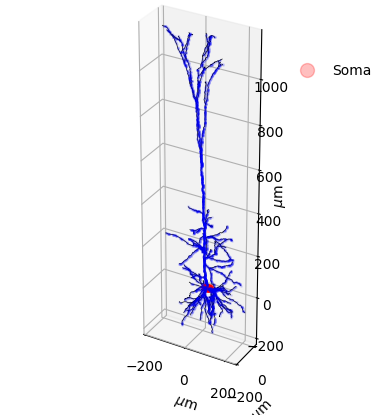

In [18]:
pp = [0.8,0.2]

ee,loc,dendIdx = Background(Sections,numNoiseInputs,pp=pp,Plot=True)

numNoiseInputs = len(ee)


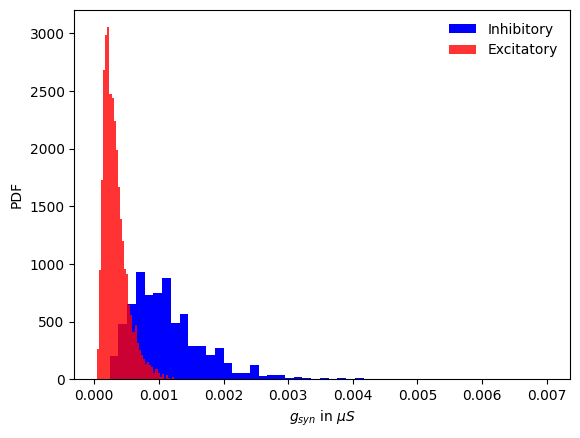

In [19]:

#typical magnitude order 0.001 microSiemens

#weight = np.random.lognormal(np.log(We[Case]),1,numNoiseInputs) #We[Case] #* us #microsiemens

ww = We["Both"]

weightE = np.random.lognormal(np.log(ww),0.55,np.sum(ee>=0)) #We[Case] #* us #microsiemens
weightI = np.random.lognormal(np.log(0.001),0.5,np.sum(ee<0)) #We[Case] #* us #microsiemens

#weight = 0.08*us

pyplot.hist(weightI,bins=50,density=True,label='Inhibitory',color='b')

pyplot.hist(weightE,bins=50,density=True,alpha=0.8,label='Excitatory',color="r")

#dw = 1e-3

#len(np.arange(0.000025,0.001+dw,dw))
np.max(weightE)

pyplot.xlabel(r"$g_{syn}$ in $\mu S$")
pyplot.ylabel(r"PDF")

pyplot.legend(frameon=False)

pyplot.savefig("Weights_dist.png",dpi=400,bbox_inches="tight")


In [20]:
#BACKGROUND NOISE
I_indx = np.where(ee<0)[0]
E_indx = np.where(ee>=0)[0]


In [21]:

DDE = pd.DataFrame(columns=["W","Indx"])
DDE["W"] = weightE
DDE["Indx"] = dendIdx[E_indx]

DDI = pd.DataFrame(columns=["W","Indx"])
DDI["W"] = weightI
DDI["Indx"] = dendIdx[I_indx]

TotalWE = DDE.groupby(by=["Indx"]).sum()
TotalWI = DDI.groupby(by=["Indx"]).sum()

ToWE = np.array(TotalWE.values).flatten()
Toidx = np.array(TotalWE.index)[np.argsort(ToWE)]


In [22]:
Asections = [np.pi*eval("h."+str(i)).psection()["morphology"]["L"]*np.mean(eval("h."+str(i)).psection()["morphology"]["diam"]) for i in Sections]

TotalArea = np.sum(Asections)

Synapdensity = numNoiseInputs/TotalArea

NumSynap_perSec = np.int32(np.round(Synapdensity*np.array(Asections)))

dendIdx = np.repeat(np.arange(0,len(Sections)),NumSynap_perSec)

numNoiseInputs = len(dendIdx)


In [23]:

#tnwe = Asections/np.max(Asections)
#tnwe = ToWE/(np.mean(ToWE)+10*np.std(ToWE))
#clors = pyplot.cm.rainbow(tnwe)
#ax = Plot3D("Pyramidal_1",inputsIdx=[],loc=np.zeros(len(ToWE)),secIndx=Toidx,SS=2,SSa=1,cl=clors,clp=clors,LW=1)


<Axes3D: xlabel='$\\mu$m', ylabel='$\\mu$m', zlabel='$\\mu$m'>

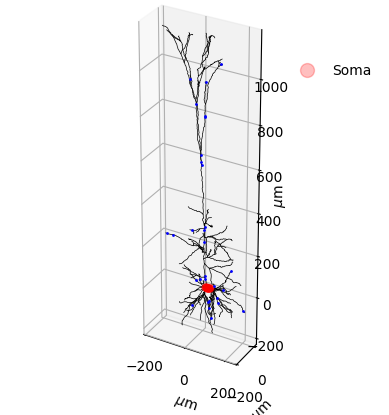

In [24]:
Chos = dendIdx[np.where(weightE>0.001)[0]]
locChos = loc[np.where(weightE>0.001)[0]]

Plot3D("Pyramidal_1",inputsIdx=Chos,loc=locChos,SS=1,SSa=1)


In [25]:
BifLev,SecLev = BranchingLevel(List)

In [26]:

def PlotBranching(BifLev,SecLev):

    import matplotlib.pyplot as plt

    clors = plt.cm.rainbow(np.linspace(0,1,len(1+np.unique(BifLev[:,1]))))

    cl = []
    clp = []

    for i in BifLev[:,1]:
        cl.append(clors[i-1])

    for i in SecLev[:,1]:
        clp.append(clors[i-1])

    print(len(clp),len(SecLev))
    
    ax = Plot3D("Pyramidal_1",inputsIdx=BifLev[:,0],loc=np.zeros(len(BifLev[:,0])),secIndx=SecLev[:,0],SS=2,SSa=1,cl=cl,clp=clp,LW=0.5)

    return ax


194 194


<Axes3D: xlabel='$\\mu$m', ylabel='$\\mu$m', zlabel='$\\mu$m'>

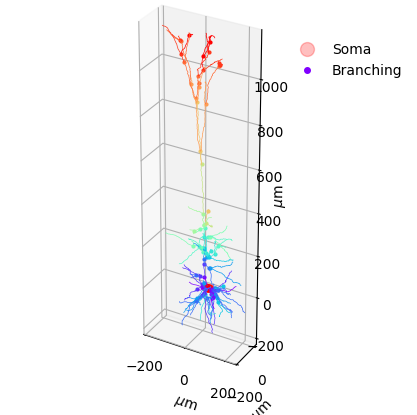

In [27]:
PlotBranching(BifLev,SecLev)

In [28]:
def Sample_inputs(List,dist_bet=100,dis_start=0,dis_end=0,num=2):
    """
    Indentify the number of possible inputs between a path length interval dis_start and dis_end that
    can be selected in the dendritic when they are equidistantly distributed. Then sample a number of 
    inputs for each distance and each branching level present between the possible inputs.
    
    The distance of inputs will be always integer multiples of dist_bet.
    Branching level refeer to number of bifurcations that exist between the soma and the given input point.
    
    Params:
    -List: Morphology info DataFrame.
    -dist_bet: Distance between inputs (Default=100 micras)
    -dis_start: Minimum distance of sampling (if 0, will take the minimum pathlenght, usually the lengh of shortes section).
    -dis_end: Maximum distance of sampling (if 0, will take the maximum pathlenght present in the tree).
    -num: Number of samples for each Distance and Branching Level.
    
    Return
        An nd-array with List of Inputs Info: 
            Column 1: Index, 
            Column 2: Input localization in the section, 
            Column 3: Input Distance from soma,
            Column 4: Input Level 
    """
    BifLev,SecLev = BranchingLevel(List)
    
    InpSecIndx,InpSecloc,InpDist,InpAvgDiam = Inputs_dist(List,ipls=dist_bet,Li=dis_start,Lf=dis_end)

    #InfoInp = pd.DataFrame()

    #InfoInp["InpIndx"] = InpSecIndx
    #InfoInp["Loc"] = InpSecloc
    #InfoInp["Dist"] = InpDist
    #InfoInp["InpAvgDiam"] = InpDist
    #InfoInp["Level"] = SecLev[InpSecIndx,1]
    
    InpSecLev = SecLev[InpSecIndx,1]
    
    sig = 3
    
    Dist,Num = np.unique(InpDist,return_counts=True)
    Lev,NumL = np.unique(InpSecLev,return_counts=True)
    Diam,NumL = np.unique(np.round(InpAvgDiam,sig),return_counts=True)
    
    dendInpIndx = []
    dendloc = []
    denddis = []
    dendlev = []
    dendavgdiam = []
    
    for i in range(len(Dist)):
        for j in range(len(Lev)):
            for k in range(len(Diam)):
                
                dd = np.where((InpDist==Dist[i])&(InpSecLev==Lev[j])&(np.round(InpAvgDiam,sig)==Diam[k]))[0]
        
                if len(dd)>=num:

                    indx = np.random.choice(dd,num,replace=False)

                    dendInpIndx.append(InpSecIndx[indx])
                    dendloc.append(InpSecloc[indx])
                    denddis.append(InpDist[indx])
                    dendlev.append(InpSecLev[indx])
                    dendavgdiam.append(InpAvgDiam[indx])

            #elif len(dd)>0:

            #    dendInpIndx.append(InpSecIndx[dd])
            #    dendloc.append(InpSecloc[dd])
            #    denddis.append(InpDist[dd])
            #    dendlev.append(InpSecLev[dd])

    dat = []
    
    dendInpIndx0 = []
    
    for i in range(len(dendInpIndx)):

        for j in range(len(dendInpIndx[i])):
            
            if dendInpIndx[i][j] not in dendInpIndx0:
                
                dendInpIndx0 += dendInpIndx[i][j]
                
                dat.append([dendInpIndx[i][j],dendloc[i][j],denddis[i][j],dendlev[i][j]])

    return dat


In [100]:
di = [['Basal',0,150,50],
     ['Mid',150,800,40],
     ['Api',800,0,50]
     ]

Data = pd.DataFrame()

for i in range(len(di)):
    
    Inpsample = Sample_inputs(List,dist_bet=di[i][3],dis_start=di[i][1],dis_end=di[i][2],num=2)

    dendIndxInp = np.int32(np.array(Inpsample)[:,0])
    dendlocInp = np.float32(np.array(Inpsample)[:,1])
    Diameter = [np.round(np.mean(eval("h."+str(Sections[k])).psection()["morphology"]["diam"]),3) for k in dendIndxInp]
    
    print("Num "+di[i][0],len(Inpsample))

    Data0 = pd.DataFrame()

    Data0["InpIndx"] = dendIndxInp
    Data0["loc"] = dendlocInp
    Data0["Distance"] = np.float32(np.array(Inpsample)[:,2])
    Data0["Level"] = np.int32(np.array(Inpsample)[:,3])
    Data0["AvgDia"] = Diameter
    Data0["Category"] = [di[i][0]]*len(Inpsample)

    Data = pd.concat([Data,Data0])
    
Data.to_csv("Inputs_info_"+Case+".csv",index=False)

Data

Num Basal 18
Num Mid 16
Num Api 16


,InpIndx,loc,Distance,Level,AvgDia,Category
0,9,0.401,50.0,2,0.29,Basal
1,82,0.059,50.0,2,0.29,Basal
2,65,0.250,50.0,2,0.58,Basal
3,36,0.411,50.0,2,0.58,Basal
4,73,0.534,50.0,2,0.88,Basal
5,83,0.464,50.0,2,0.88,Basal
6,26,0.124,50.0,3,0.88,Basal
7,39,0.520,50.0,3,0.88,Basal
8,29,0.176,50.0,4,0.88,Basal
9,55,0.187,50.0,4,0.88,Basal


<Axes3D: xlabel='$\\mu$m', ylabel='$\\mu$m', zlabel='$\\mu$m'>

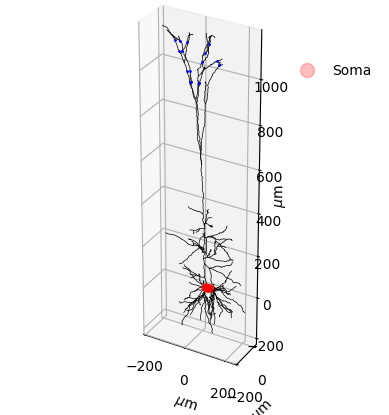

In [101]:
Plot3D("Pyramidal_1",inputsIdx=dendIndxInp,loc=dendlocInp,SS=1,SSa=1)

In [109]:
#Data.groupby(by=["Distance","Level","AvgDia","Category"]).describe()
#Data = pd.read_csv("Inputs_info_"+Case+"_num_"+str(len(Inpsample))+".csv")
Data = pd.read_csv("Inputs_info_"+Case+".csv")

dendIndxInp = Data.InpIndx.values
dendlocInp = Data['loc'].values

IndB = np.random.choice(Data[Data.Category == 'Basal'].index,2,replace=False)
IndM = np.random.choice(Data[Data.Category == 'Mid'].index,2,replace=False)
IndA = np.random.choice(Data[Data.Category == 'Api'].index,2,replace=False)

Inpidx_sel = np.array([dendIndxInp[IndB],dendIndxInp[IndM],dendIndxInp[IndA]]).flatten()
Inploc_sel = np.array([dendlocInp[IndB],dendlocInp[IndM],dendlocInp[IndA]]).flatten()


<Axes3D: xlabel='$\\mu$m', ylabel='$\\mu$m', zlabel='$\\mu$m'>

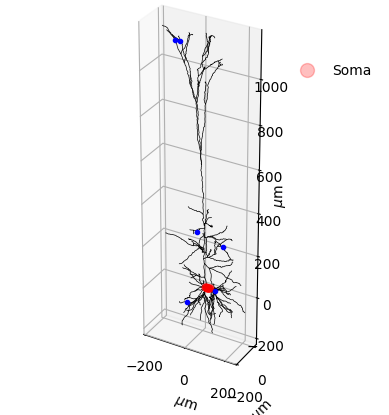

In [96]:
Plot3D("Pyramidal_1",inputsIdx=Inpidx_sel,loc=Inploc_sel,SS=3,SSa=1)

<Axes3D: xlabel='$\\mu$m', ylabel='$\\mu$m', zlabel='$\\mu$m'>

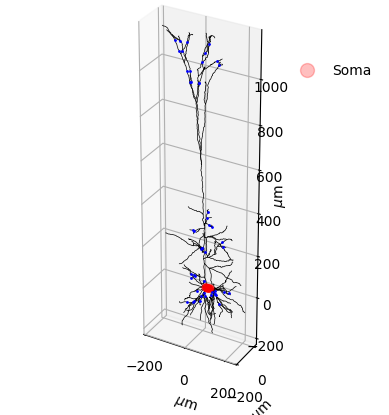

In [32]:
#Plot3D("Pyramidal_synap",inputsIdx=[dendIdx[E_indx[i]],dendIdx[I_indx[i]]],loc=[loc[E_indx[i]],loc[I_indx[i]]],SS=3,SSa=0.5)


258

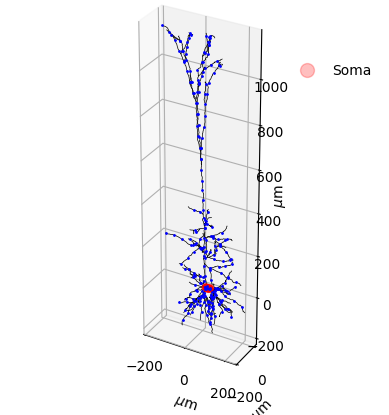

In [97]:

InpSecIndx,InpSecloc,InpDist,InpDia = Inputs_dist(List,ipls=50)

InfoInp = pd.DataFrame()

InfoInp["InpIndx"] = InpSecIndx
InfoInp["Loc"] = InpSecloc
InfoInp["Dist"] = InpDist
InfoInp["Dia"] = InpDia

InfoInp["Level"] = SecLev[InpSecIndx,1]

Plot3D("Pyramidal_1",inputsIdx=InpSecIndx,loc=InpSecloc,SS=1,SSa=1)

len(InpSecIndx)


In [34]:
#BACKGROUND NOISE
I_indx = np.where(ee<0)[0]
E_indx = np.where(ee>=0)[0]


In [35]:
tmax

210000

In [34]:

"""
DendriticRegions = {"Basal":[90,120],"Middle":[200,500],"Apical":[1000,1300]}

Region0 = "Apical"

IndxSour0 = Select_Input_sections(List,Sections,rangeL=DendriticRegions[Region0])[1]

Region1 = "Apical"

IndxSour1 = Select_Input_sections(List,Sections,rangeL=DendriticRegions[Region1])[0]

Region = Region0+Region1

IndxSour = np.array([IndxSour0,IndxSour1])

IndxSour = [159, 142]
"""

"""
weidx = np.where((weightE>0.001)&(weightE<0.0011))[0]
wiidx = np.where((weightI>0.001)&(weightI<0.0011))[0]

print(weidx,wiidx)

indexMonit = [(1028,188),(3809,484),(3299,700)]

for j,i in enumerate(indexMonit):

    ie,ii = i

    print(ie,ii)
    
    Plot3D("Pyramidal_synap_"+str(j)+".png",inputsIdx=[dendIdx[E_indx[ie]],dendIdx[I_indx[ii]]],loc=[loc[E_indx[ie]],loc[I_indx[ii]]],sTyp=["r","b"],SS=3,SSa=0.5)


#IdxSour = Select_Input_sections(List,Sections,dendIdx,Cell=CellName,rangeL=DendriticRegions[Region])

#NumSen = 10

#MonitPoints = Select_Noise_sections(List,Sections,Cell=CellName,numNoiseInputs=NumSen)

#MonitPoints = [i for i in range(len(Sections)) if "soma" not in str(Sections[i])]

#NumSen = len(MonitPoints)

#InputsMonit = []

#for i in range(len(Sections)):

#    SS = np.where(dendIdx==i)[0]
    
#    InputsMonit.append(np.random.choice(SS,1)[0])

#Creating Input (spiking time)
#stimulationsCorr = CorrInputs(tmax,rate)

#Just in case of monitoring membrane potential in this points
MonitPoints = dendIndxInp 

Monitloc = dendlocInp

NumSen = len(dendIndxInp)
"""

print("NADA")


NADA


In [36]:
np.random.seed(123456)

# background stimulus (NetStim) parameters
isi = 400*ms         # mean interspike time interval
num = 50+tmax*ms/isi           # average number of spikes
start = 1*ms        # stimulus start time
stop = tmax*ms      # simulation stop time
noise = 1         # noise parameter (must be a value from 0 to 1)

seeds = np.random.randint(10000, size=numNoiseInputs)

#"""
# input stimulus (NetStim) parameters
isiInp = 100*ms         # mean interspike time interval
#Stimulus average duration
StiDur = tmax #ms
numInp = (StiDur/isiInp)  + 50          # average number of spikes
startInp = 5000*ms        # stimulus start time
stop = tmax*ms      # simulation stop time

listInp = [0,1,29,30,45,46]

numSour = len(dendIndxInp[listInp])

seedsInp = np.random.randint(10000, size=numSour)
#"""

WeiInp = 0.004 #microS

numInp

2150.0

<Axes3D: xlabel='$\\mu$m', ylabel='$\\mu$m', zlabel='$\\mu$m'>

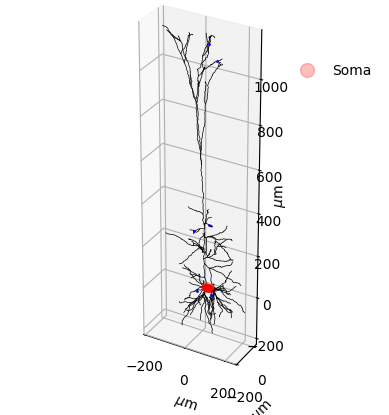

In [39]:
Plot3D("Pyramidal_1",inputsIdx=dendIndxInp[[0,1,29,30,45,46]],loc=dendlocInp[[0,1,29,30,45,46]],SS=1,SSa=1)


In [40]:

# create synapses I
synapses_GABA = [createSynapse(Sections,dendIdx[i], loc=loc[i], tau=tau_GABA, e=ee[i]) for i in I_indx]
synapses_AMPA = [createSynapse(Sections,dendIdx[i], loc=loc[i], tau=tau_AMPA, e=ee[i]) for i in E_indx]
synapses_NMDA = [createNMDA_Synapse(Sections,dendIdx[i], loc=loc[i], tau=tau_NMDA, e=ee[i]) for i in E_indx]

# create inputs
BackGroundstim = [createStim(isi=isi, num=num, start=start, noise=noise, seed=seeds[i]) for i in range(numNoiseInputs)]

# connect inputs to synapses I
connections_GABA = [connectStim(synapses_GABA[i], BackGroundstim[I_indx[i]], delay=delay, weight=weightI[i]) for i in range(len(I_indx))]

# connect inputs to synapses E
connections_AMPA = [connectStim(synapses_AMPA[i], BackGroundstim[E_indx[i]], delay=delay, weight=weightE[i]) for i in range(len(E_indx))]

# connect inputs to synapses E
connections_NMDA = [connectStim(synapses_NMDA[i], BackGroundstim[E_indx[i]], delay=delay, weight=weightE[i]) for i in range(len(E_indx))]

# create inputs
InputsStim = [createStim(isi=isiInp, num=numInp, start=startInp, noise=noise, seed=seedsInp[i]) for i in range(numSour)]

# create synapses Inputs
Inpsynapses_AMPA = [createSynapse(Sections,dendIndxInp[i], loc=dendlocInp[i], tau=tau_AMPA, e=0) for i in listInp]
Inpsynapses_NMDA = [createNMDA_Synapse(Sections,dendIndxInp[i], loc=dendlocInp[i], tau=tau_NMDA, e=0) for i in listInp]

# connect inputs to synapses E
Inpconnections_AMPA = [connectStim(Inpsynapses_AMPA[i], InputsStim[i], delay=delay, weight=WeiInp) for i in range(numSour)]

# connect inputs to synapses E
Inpconnections_NMDA = [connectStim(Inpsynapses_NMDA[i], InputsStim[i], delay=delay, weight=WeiInp) for i in range(numSour)]

#create synapses in non apical den (?)
#synapsesSour = [createSynapse(Sections,IdxSour[i], loc=loc, tau=tauE, e=0.) for i in range(numSour)]

# connect inputs to synapses
# connectionsSour = [connectStim(synapsesSour[i], stimulationsCorr[i], delay=delay, weight=0.2) for i in range(numSour)]


In [41]:
#Track all synapses
EverySyn = synapses_GABA+synapses_AMPA+synapses_NMDA+Inpsynapses_AMPA+Inpsynapses_NMDA


In [42]:
# prepare output variable
recordings = {'Vsoma': h.Vector(),
#              'SynCur': [h.Vector() for i in range(2*len(weightE)+len(weightI)+2*numSour)],
#              'timeSynCur': h.Vector(),
             'input': [h.Vector() for i in range(numSour)],
             'inputTime': [h.Vector() for i in range(numSour)],
#             'dendrite': [h.Vector() for i in range(numSour)],
#             'sensors_I': [h.Vector() for i in range(3)],
#             'sensors_E': [h.Vector() for i in range(3)],
#              'sensors': [h.Vector() for i in range(len(dendIndxInp))],
#              'synapse_GABA': [h.Vector() for i in range(3)],
#              'synapse_AMPA': [h.Vector() for i in range(3)],
#              'synapse_NMDA': [h.Vector() for i in range(3)],
              'time': h.Vector()}

ddt = 10*dt

# set up recordings
recordings['Vsoma'].record(Soma[0](0.5)._ref_v,ddt) # soma membrane potential

recordings['time'].record(h._ref_t,ddt) # time steps

Dt = 1

#for i in range(len(EverySyn)):

#    recordings['SynCur'][i].record(EverySyn[i]._ref_i,Dt)
#    recordings['timeSynCur'].record(h._ref_t,Dt) # time steps

for i, sen0 in enumerate(dendIndxInp[listInp]):

    Inpconnections_AMPA[i].record(recordings['inputTime'][i], recordings['input'][i])
    
    #recordings['sensors'][i].record(Sections[sen0](dendlocInp[i])._ref_v,0.1)

#for j,i in enumerate(indexMonit):
#   ie,ii = i
#   recordings['dendrite'][i].record(Sections[dend0](loc[dend0])._ref_v)
#   recordings['sensors_I'][j].record(Sections[dendIdx[I_indx[ii]]](loc[I_indx[ii]])._ref_v)
#   recordings['sensors_E'][j].record(Sections[dendIdx[E_indx[ie]]](loc[E_indx[ie]])._ref_v)
#   recordings['synapse_GABA'][j].record(synapses_GABA[ii]._ref_i)
#   recordings['synapse_AMPA'][j].record(synapses_AMPA[ie]._ref_i)
#   recordings['synapse_NMDA'][j].record(synapses_NMDA[ie]._ref_i)
#   Inpconnections_AMPA[dend0].record(recordings['inputTime'][i], recordings['input'][i])


In [ ]:

h.finitialize(-65 * mV)

h.continuerun(tmax*ms)


In [ ]:
#from scipy.io import savemat

#savemat("Trial_experiments_"+str(WeiInp)+".mat",recordings)


In [ ]:
# convert outputs into numpy arrays
for k,v in recordings.items():
    if k=='Vsoma' or k=='time' or k=='timeSynCur':
        recordings[k] = np.array(list(recordings[k]))
    else:
        recordings[k] = [np.array(list(recordings[k][i])) for i in range(len(recordings[k]))]


In [ ]:
ini = tmax-1500


In [ ]:
ifi = tmax

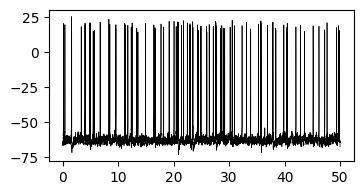

In [79]:
cm = 1/2.54

fig,ax = pyplot.subplots(1,1,figsize=(10*cm,5*cm)) # Default figsize is (8,6)

soma_plot = ax.plot(recordings["time"]/1000, recordings["Vsoma"], color='black',label="AP in soma",lw=0.5)


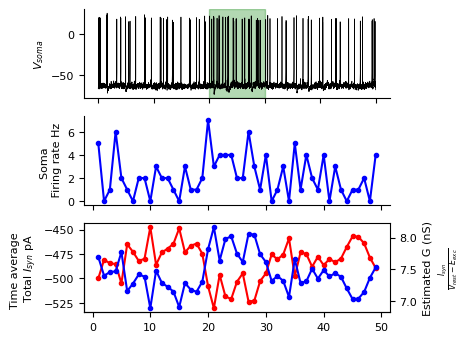

In [82]:
cm = 1/2.54

fs = 8

fig,ax = pyplot.subplots(3,1,figsize=(10*cm,10*cm)) # Default figsize is (8,6)

soma_plot = ax[0].plot(recordings["time"]/1000, recordings["Vsoma"], color='black',label="AP in soma",lw=0.5)

thres = -30

ax[0].axvspan(20,30,color='green',alpha=0.3)

#ax[0].hlines(thres,0,tmax,color="red",linestyle='dashed')

#ax[0].set_xlim(ini, ifi)
#ax[0].set_xlabel('time (ms)')

import matplotlib as mpl

cmap = mpl.colormaps['Blues_r']
#spacing = cmap.N//NumSen
spacing = cmap.N//5

colours = cmap(np.arange(0, cmap.N, spacing))

spt = (np.sign(np.diff((1*(recordings["Vsoma"]>thres))))>0)

TW = tmax/(ddt)
tw = np.int32(1000/(ddt))
nT = np.int32(TW/tw)

Sc = np.zeros(nT-1)

for tt in range(1,nT):

    Sc[tt-1] = np.sum(spt[tt*tw:(tt+1)*tw])
    
SCur = np.array(recordings["SynCur"])

TotSynCur = np.sum(SCur,axis=0)

TWs = tmax/Dt
tws = np.int32(1000/Dt)
nTs = np.int32(TWs/tws)

TSc = np.zeros(nTs-1)
TScstd = np.zeros(nTs-1)

for tt in range(1,nTs):

    TSc[tt-1] = np.mean(TotSynCur[tt*tws:(tt+1)*tws])
    TScstd[tt-1] = np.std(TotSynCur[tt*tws:(tt+1)*tws])

ax[1].plot(np.arange(1,nT),Sc,'ob-',ms=3)

ax[2].plot(np.arange(1,nTs),TSc*1000,'or-',ms=3)

ax2 = ax[2].twinx()

ax2.plot(np.arange(1,nTs),(TSc/(-65))*1000,'-ob',ms=3)

ax2.tick_params(labelsize=fs)

ax2.set_ylabel("Estimated G (nS)\n"+r"$\frac{I_{syn}}{V_{rest}-E_{exc}}$",fontsize=fs)

#ax[1].set_xlim(0,26000)
#ax[2].set_xlim(0,26000)

fs = 8

ax[0].set_ylabel(r"$V_{soma}$",fontsize=fs)

ax[1].set_ylabel("Soma \n Firing rate Hz",fontsize=fs)
ax[2].set_ylabel("Time average \n"+r"Total $I_{syn}$ pA",fontsize=fs)

ax[0].tick_params(labelsize=fs,labelbottom=False)
ax[1].tick_params(labelsize=fs,labelbottom=False)
ax[2].tick_params(labelsize=fs)

#ax[2].plot(recordings["time"],recordings["synapse_AMPA"][ni],color="red",label="AMPA")
ax[0].spines[['right','top']].set_visible(False)
ax[1].spines[['right','top']].set_visible(False)
ax[2].spines[['right','top']].set_visible(False)

pyplot.savefig("Trial_6inp_experiment.png",dpi=400,bbox_inches="tight")


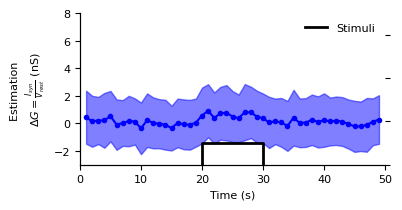

In [83]:

fig,ax = pyplot.subplots(1,1,figsize=(10*cm,5*cm)) # Default figsize is (8,6)

Average = 0.5*(np.mean((TSc/(-65))[10:19])+np.mean((TSc/(-65))[40:]))

ax.plot(np.arange(1,nTs),(TSc/(-65)-Average)*1000,'-ob',ms=3)

ax.fill_between(np.arange(1,nTs),1000*((TSc/(-65))-Average-TScstd/(-65)),1000*((TSc/(-65))-Average+TScstd/(-65)),color='b',alpha=0.5)

ax.tick_params(labelsize=fs)

ax1 = ax.twinx()

ax1.plot([20,20,30,30],[0,1,1,0],'-k',lw=2,label="Stimuli")

ax1.tick_params(labelsize=fs,labelright=False)

ax1.spines[['right','top']].set_visible(False)
ax.spines[['right','top']].set_visible(False)

ax1.set_ylim(0,7)
ax.set_ylim(-3,8)

ax.set_ylabel("Estimation \n"+r"$\Delta G=\frac{I_{syn}}{V_{rest}}$ (nS)",fontsize=fs)

ax.set_xlabel("Time (s)",fontsize=fs)

ax.set_xlim(0,50)

ax1.legend(frameon=False,fontsize=fs)

pyplot.savefig("Delta_6inp_conductance_estimation.png",dpi=400,bbox_inches="tight")


In [84]:

SCur = np.array(recordings["SynCur"])


In [85]:
Spik = 1*(np.abs(SCur)>0.0001)

Spik.shape

(9004, 50000)

In [86]:
InpSpk = np.zeros(Spik.shape,dtype=np.int32)

for i in range(Spik.shape[0]):
    InpSpk[i,np.where(np.diff(Spik[i,:])>0)[0]] = 1


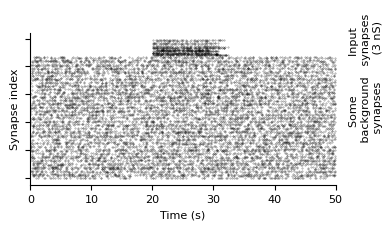

In [88]:
spktime = np.where(InpSpk[-100:,:]==1)

fig,ax = pyplot.subplots(1,1,figsize=(10*cm,5*cm)) # Default figsize is (8,6)

ax.scatter(spktime[1]/1000,spktime[0],s=0.1,c='k',alpha=0.5)

ax.tick_params(labelsize=fs,labelleft=False)

ax.set_xlim(0,50)

ax.set_ylabel("Synapse index",fontsize=fs)

ax.spines[['right','top']].set_visible(False)

ax.set_xlabel("Time (s)",fontsize=fs)

ax.text(55,100,'Input \n synapses \n (3 nS)',rotation=90,fontsize=fs,ha='center',va='center')

ax.text(55,50,'Some \n background \n synapses',rotation=90,fontsize=fs,ha='center',va='center')

pyplot.savefig("Raster_plot_experiment_6inp.png",dpi=300,bbox_inches="tight")

In [47]:

np.mean(np.sum(InpSpk[:-100,:],axis=1)/(tmax*1e-3)),1/(400*1e-3)


(2.337565853743633, 2.5)

In [127]:

cc = 1*(recordings["soma"]>-30)[np.int32(200/dt):]

spkt = np.where(np.diff(cc)>0)[0]*dt

freq = np.round(len(spkt)/((tmax-200)*1e-3),1)

freq


3.9

In [128]:
dw = 2e-5

WW = np.arange(2e-4,8e-4+dw,dw)

len(WW)

32

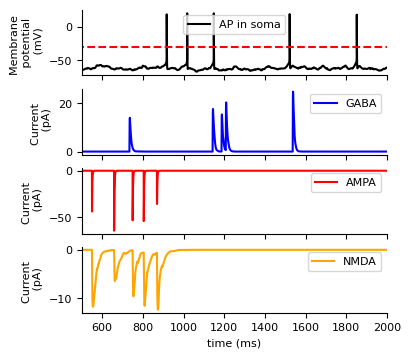

In [129]:
cm = 1/2.54

fig,ax = pyplot.subplots(4,1,figsize=(10*cm,10*cm)) # Default figsize is (8,6)

soma_plot = ax[0].plot(recordings["time"], recordings["soma"], color='black',label="AP in soma")

thres = -30

ax[0].hlines(thres,0,tmax,color="red",linestyle='dashed')

#ax[0].set_xlim(ini, ifi)
#ax[0].set_xlabel('time (ms)')

import matplotlib as mpl

cmap = mpl.colormaps['Blues_r']
#spacing = cmap.N//NumSen
spacing = cmap.N//5

colours = cmap(np.arange(0, cmap.N, spacing))

ni = 2

ax[1].plot(recordings["time"],1000*recordings["synapse_GABA"][ni],color="blue",label="GABA")

ax[2].plot(recordings["time"],1000*recordings["synapse_AMPA"][ni],color="red",label="AMPA")

ax[3].plot(recordings["time"],1000*recordings["synapse_NMDA"][ni],color="orange",label="NMDA")

fs = 8

for i in range(4):    
    ax[i].set_xlim(ini, ifi)

    ax[i].legend(fontsize=fs)
    
    if i==3:
        ax[i].set_xlabel('time (ms)',fontsize=fs)
    
    if i>0:
        ax[i].set_ylabel('Current \n (pA)',fontsize=fs)
    else:
        ax[i].set_ylabel('Membrane \n potential \n (mV)',fontsize=fs)

    ax[i].tick_params(labelsize=fs)
    
    if i<3:
        ax[i].tick_params(labelbottom=False)

    ax[i].spines[["top","right"]].set_visible(False)

pyplot.savefig("Currents_synp_"+str(ni)+"_"+Case+".png",dpi=500,bbox_inches="tight")


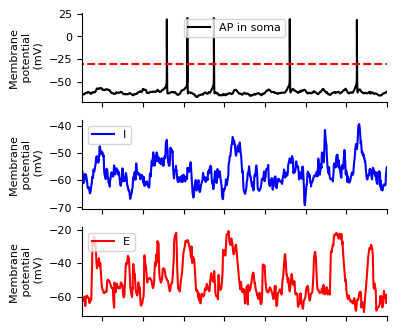

In [130]:
cm = 1/2.54

fig,ax = pyplot.subplots(3,1,figsize=(10*cm,10*cm)) # Default figsize is (8,6)

soma_plot = ax[0].plot(recordings["time"], recordings["soma"], color='black',label="AP in soma")

thres = -30

ax[0].hlines(thres,0,tmax,color="red",linestyle='dashed')

#ax[0].set_xlim(ini, ifi)
#ax[0].set_xlabel('time (ms)')

import matplotlib as mpl

cmap = mpl.colormaps['Blues_r']
#spacing = cmap.N//NumSen
spacing = cmap.N//5

colours = cmap(np.arange(0, cmap.N, spacing))

ni = 2

ax[1].plot(recordings["time"],recordings["sensors_I"][ni],color="blue",label="I")

ax[2].plot(recordings["time"],recordings["sensors_E"][ni],color="red",label="E")

fs = 8

for i in range(3):    
    ax[i].set_xlim(ini, ifi)

    ax[i].legend(fontsize=fs)
    
    if i==3:
        ax[i].set_xlabel('time (ms)',fontsize=fs)
    
    if i>0:
        ax[i].set_ylabel('Membrane \n potential \n (mV)',fontsize=fs)
    else:
        ax[i].set_ylabel('Membrane \n potential \n (mV)',fontsize=fs)

    ax[i].tick_params(labelsize=fs)
    
    if i<3:
        ax[i].tick_params(labelbottom=False)

    ax[i].spines[["top","right"]].set_visible(False)

pyplot.savefig("Potentials_synp_"+str(ni)+"_"+Case+".png",dpi=500,bbox_inches="tight")


<Axes3D: xlabel='$\\mu$m', ylabel='$\\mu$m', zlabel='$\\mu$m'>

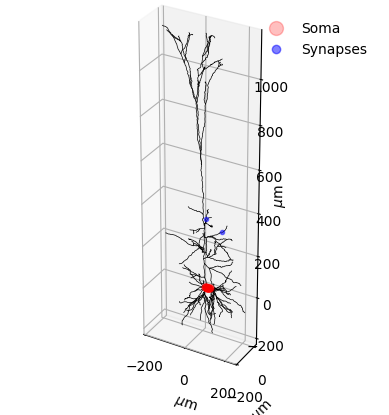

In [184]:
ie,ii = indexMonit[1]

Plot3D("Pyramidal_synap_"+str(j)+".png",inputsIdx=[dendIdx[E_indx[ie]],dendIdx[I_indx[ii]]],loc=[loc[E_indx[ie]],loc[I_indx[ii]]],SS=3,SSa=0.5)


In [38]:
from scipy.io import savemat

sensorsVm = np.zeros([len(recordings["sensors"]),int(tmax/dt)+1])

twindows = 1

for i in range(len(recordings["sensors"])):
    
    sensorsVm[i,:] = recordings["sensors"][i]
    
sensorsVm0 = sensorsVm[:,::twindows] 

mdic = {"Soma":recordings["soma"][::twindows],"Sensors":sensorsVm0,"dt":dt*twindows}


In [39]:
savemat("DATA/Potential_values_sim"+Case+"_"+str(tmax)+"_Cell_"+CellName+"_timebin_"+str(timebin)+"_numinputs_"+str(numNoiseInputs)+"_ISInoise_"+str(isi)+"_avgnumspikes_"+str(num)+".mat",mdic)


(-65.0, 25.0)

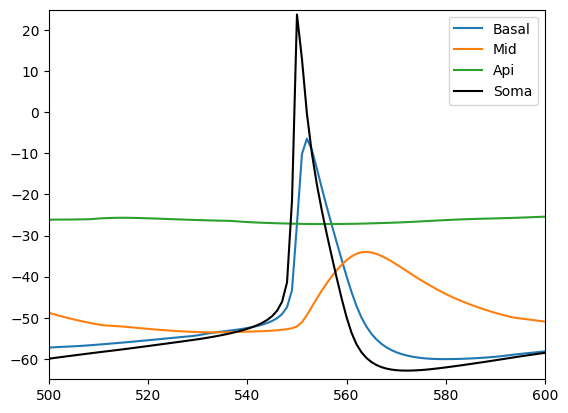

In [29]:
import matplotlib.pyplot as plt

#plt.hist(sensorsVm[-1],bins=50,density=True);

plt.plot(sensorsVm0[0],label=Data[Data["InpIndx"]==dendIndxInp[0]].Category.values[0])

plt.plot(sensorsVm0[25],label=Data[Data["InpIndx"]==dendIndxInp[25]].Category.values[0])

plt.plot(sensorsVm0[-1],label=Data[Data["InpIndx"]==dendIndxInp[-1]].Category.values[0])

plt.plot(recordings["soma"][::twindows],color="k",label="Soma")

plt.legend()

plt.xlim(5000/twindows,6000/twindows)

plt.ylim(-65,25)


In [74]:
from scipy.io import loadmat

loadmat("Potential_values_sim"+Case+"_"+str(tmax)+"_Cell_"+CellName+"_timebin_"+str(timebin)+"_numinputs_"+str(numNoiseInputs)+"_ISInoise_"+str(isi)+"_avgnumspikes_"+str(num)+".mat")


{'__header__': b'MATLAB 5.0 MAT-file Platform: posix, Created on: Fri Jul  5 02:49:20 2024',
 '__version__': '1.0',
 '__globals__': [],
 'Soma': array([[-65.        , -65.13180722, -65.23705292, ..., -63.41793251,
         -63.3972662 , -63.36969528]]),
 'Sensors': array([[-65.        , -65.07987348, -65.17180298, ..., -61.75256185,
         -61.83347411, -61.89962328],
        [-65.        , -65.08130755, -65.17558374, ..., -62.89276849,
         -62.3946992 , -61.96510181],
        [-65.        , -65.07831424, -65.16399059, ..., -64.72267409,
         -64.80185583, -64.86467986],
        ...,
        [-65.        , -64.93005273, -64.86284901, ..., -50.71905696,
         -50.76241849, -50.81418486],
        [-65.        , -64.92811098, -64.85750798, ..., -58.71855462,
         -58.62841207, -58.54336433],
        [-65.        , -64.9321922 , -64.86402153, ..., -55.74576631,
         -55.71585608, -55.68932913]]),
 'dt': array([[0.125]])}

In [51]:
# convert outputs into numpy arrays
for k,v in recordings.items():
    if k=='Vsoma' or k=='time' or k=='timeSynCur':
        recordings[k] = np.array(list(recordings[k]))
    else:
        recordings[k] = [np.array(list(recordings[k][i])) for i in range(len(recordings[k]))]


In [55]:
#recordings['inputTime'][0]
numSour

6

In [56]:

InputsTS = np.zeros([numSour,tmax],dtype=bool)

for i in range(numSour):
    
    InputsTS[i,np.int32(np.round(recordings["inputTime"][i]))] = 1

TimeSeries = np.zeros([len(recordings["time"]),numSour+1],dtype=np.int8)

TimeSeries[1:,0] = (np.sign(np.diff((1*(recordings["Vsoma"]>thres))))>0)

Tw = int(timebin/(10*dt))
TT = len(recordings['time'])
NT = int(TT/Tw)

TSer = np.zeros([NT,numSour+1],dtype=np.int16)

for i in range(NT-1):
    
    TSer[i,:] = 1*(np.sum(TimeSeries[Tw*i:Tw*(i+1),:],axis=0))

TSer[:,1:] = InputsTS.T

Labels = [str(Soma[0])]
Labels += [str(Sections[j]) for j in dendIndxInp[listInp]]

Data = pd.DataFrame(columns = Labels)

for i in range(len(Labels)):
    
    Data[Data.columns[i]] = TSer[:,i]

#Data.to_csv("DATA/Simulation_"+Region+"_Inputs_background_"+str(tmax)+"_Cell_"+CellName+"_timebin_"+str(timebin)+"_numinputs_"+str(numNoiseInputs)+"_ISInoise_"+str(isi)+"_avgnumspikes_"+str(num)+".csv",index=False)
Data = Data.loc[startInp+5000:,:]

Data.to_csv("DATA/Simulation_pair_PotentialMonit_Both_"+str(tmax-(startInp+5000))+"_Cell_"+CellName+"_timebin_"+str(timebin)+"_numinputs_"+str(numNoiseInputs)+"_ISInoise_"+str(isi)+"_avgnumspikes_"+str(num)+".csv",index=False)


200000

In [34]:

NumSen = len(dendIndxInp)

NumSen

50

In [80]:

TimeSeries = np.zeros([len(recordings["time"]),NumSen+1],dtype=np.int8)

TimeSeries[:,0] = 1*(recordings["soma"]>thres)

for i in range(0,NumSen,1):
    
    TimeSeries[:,i+1] = 1*(recordings['sensors'][i]>thres)

Tw = int(timebin/dt)
TT = len(recordings['time'])
NT = int(TT/Tw)

TSer = np.zeros([NT,NumSen+1],dtype=np.int8)

for i in range(NT-1):
    
    TSer[i,:] = 1*(np.sum(TimeSeries[Tw*i:Tw*(i+1),:],axis=0)>0)
    

In [81]:
Labels = [str(Soma[0])]
Labels += [str(Sections[i]) for i in dendIndxInp]

Data = pd.DataFrame(columns = Labels)

for i in range(len(Labels)):
    
    Data[Data.columns[i]] = TSer[:,i]


In [82]:

#Data.to_csv("DATA/Simulation_"+str(tmax)+"_Cell_"+CellName+"_timebin_"+str(timebin)+"_numinputs_"+str(numNoiseInputs)+"_ISInoise_"+str(isi)+"_avgnumspikes_"+str(num)+".csv",index=False)

Data.to_csv("DATA/Simulation_PotentialMonit_"+Case+"_"+str(tmax)+"_Cell_"+CellName+"_timebin_"+str(timebin)+"_numinputs_"+str(numNoiseInputs)+"_ISInoise_"+str(isi)+"_avgnumspikes_"+str(num)+".csv",index=False)
